In [1]:
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image

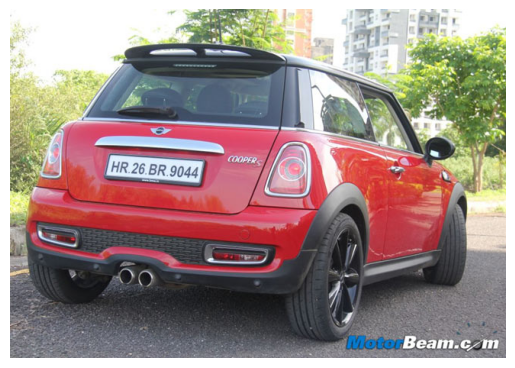

In [4]:
image = cv2.imread('./images_ocr/2.jpg', cv2.IMREAD_COLOR)

image_RGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_RGB)
plt.axis('off')
plt.show()

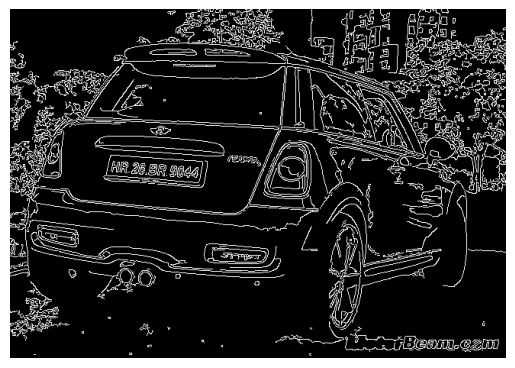

In [10]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.bilateralFilter(gray, 11, 17, 17)
edged = cv2.Canny(gray, 30, 200)

plt.imshow(edged, cmap='gray')
plt.axis('off')
plt.show()

In [22]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:10]

In [30]:
cnts[0].shape

(3351, 1, 2)

In [28]:
screenCnt = None
for i, c in enumerate(cnts):
    # 計算等高線區域周長
    peri = cv2.arcLength(c, True)
    # 轉為近似多邊形
    approx = cv2.approxPolyDP(c, 0.018 * peri, True)
    # 等高線區域維度
    print(c.shape)

    # 找第一個含四個點的多邊形
    if len(approx) == 4:
        screenCnt = approx
        print(i)
        break

(3351, 1, 2)
(411, 1, 2)
(335, 1, 2)
(184, 1, 2)
(114, 1, 2)
4


In [31]:
if screenCnt is None:
    detected = 0
    print("No contour detected")
else:
    detected = 1
    
if detected == 1:
    cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 3)
    print(f'車牌座標=\n{screenCnt}')

車牌座標=
[[[122 219]]

 [[246 227]]

 [[252 200]]

 [[132 191]]]


In [33]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask,[screenCnt],0,255,-1,)
new_image = cv2.bitwise_and(image, image, mask=mask)

In [47]:
src_pts = np.array(screenCnt, dtype=np.float32)
left = min([x[0][0] for x in src_pts])
right = max([x[0][0] for x in src_pts])
top = min([x[0][1] for x in src_pts])
bottom = max([x[0][1] for x in src_pts])
width = right - left  
height = bottom - top 
print(f'寬度={width}, 高度={height}')

寬度=130.0, 高度=36.0


In [51]:
if src_pts[0][0][0] > src_pts[1][0][0] and src_pts[0][0][1] < src_pts[3][0][1]:
    print('起始點為右下角')
    dst_pts = np.array([[width, 0], [0, 0], [0, height], [width, height]], dtype=np.float32)
elif src_pts[0][0][0] < src_pts[1][0][0] and src_pts[0][0][1] > src_pts[3][0][1]:
    print('起始點為左上角')
    dst_pts = np.array([[0, height], [width, height], [width, 0], [0, 0]], dtype=np.float32)
else:
    print('起始點為左下角')
    dst_pts = np.array([[0, 0], [0, height], [width, height], [width, 0]], dtype=np.float32)
M = cv2.getPerspectiveTransform(src_pts, dst_pts)
Cropped = cv2.warpPerspective(gray, M, (int(width), int(height)))

起始點為左上角


In [52]:
char_whitelist='ABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890'
text = pytesseract.image_to_string(Cropped, config=
           f'-c tessedit_char_whitelist={char_whitelist} --psm 6 ')
print("車牌號碼：",text)

車牌號碼： HR26BR9044



In [55]:
cv2.imshow('Orignal image',image)
cv2.imshow('Cropped image',Cropped)
cv2.imshow('gray', gray)
# 車牌存檔
cv2.imwrite('Cropped.jpg', Cropped)

# 按 Enter 鍵結束
cv2.waitKey(0)

# 關閉所有視窗
cv2.destroyAllWindows()